## Aim: Predict if Next medical appointment is show or no show
1) Multiple accuracy measures resembling different criteria used for training your decision tree classifiers.
2) Multiple accuracy measures resembling a different number of estimators used for your random forest classifiers.
3) One printed confusion matrix for the best model.

In [52]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import csv
import optuna
import time

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest ## categorical feature selection
from sklearn.feature_selection import mutual_info_classif ## categorical feature selection

from sklearn.model_selection import train_test_split ## split data

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 

import seaborn as sns


In [76]:
df = pd.read_csv("KaggleV2-May-2016.csv")

#Drop missing
dropdf=df.dropna()
print(dropdf)

## no missing value

           PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       2016-04-29T00:00:00Z   56    JARDIM D

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [77]:
## find number of NA to remove 
dropdf.isna().sum()
# no NAs 

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [23]:
## Extract features of interest: Gender, Age, Scholarship,Hipertension, Diabetes, Alcoholism, Handcap, SMS_received
df_final = df[["Gender", "Age", "Scholarship","Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received"]]
df_final.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


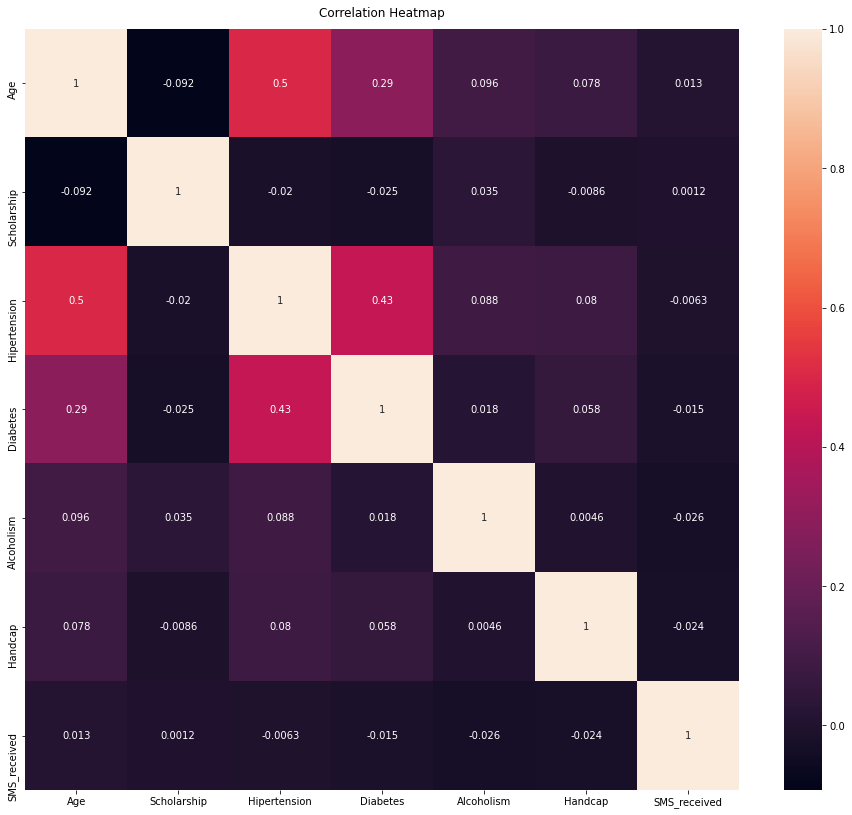

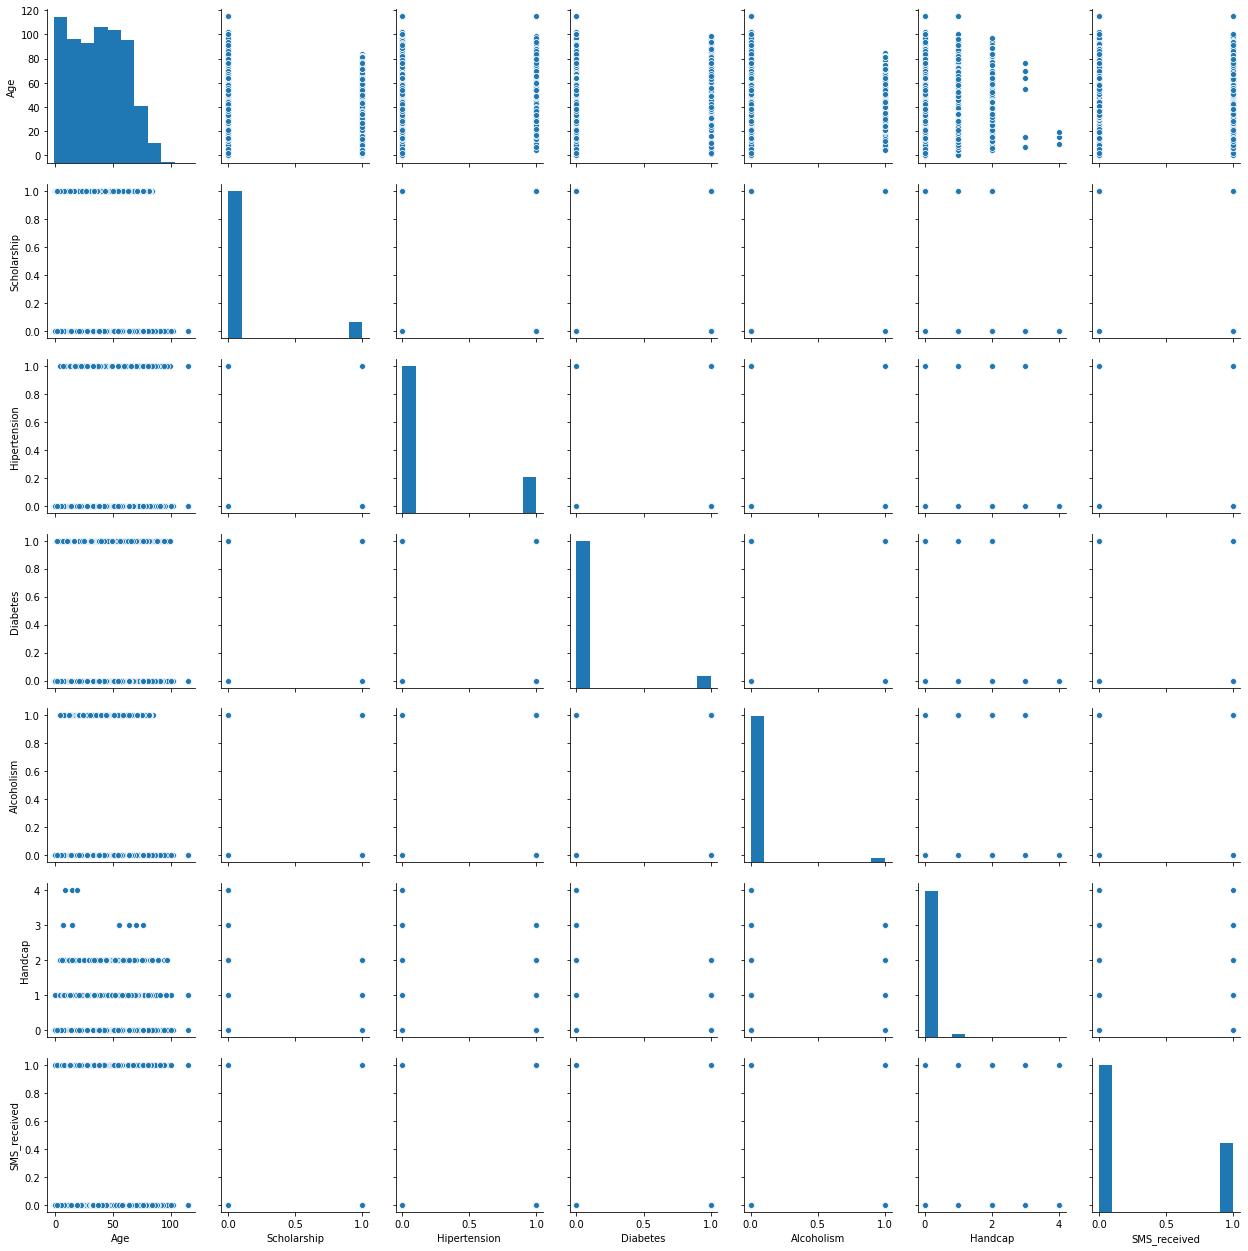

In [16]:
## EDA:
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(df_final.corr(), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

sns.pairplot(df_final)
plt.savefig('pairplot.png')
plt.show()

In [24]:
# Preprocessing
# Scaling:
scaler = MinMaxScaler()
df_num = df_final._get_numeric_data()
df_num_scale = pd.DataFrame(scaler.fit_transform(df_num))
df_num_scale.columns = df_num.columns
df_num_scale


,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,0.543103,0.0,1.0,0.0,0.0,0.0,0.0
1,0.491379,0.0,0.0,0.0,0.0,0.0,0.0
2,0.543103,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077586,0.0,0.0,0.0,0.0,0.0,0.0
4,0.491379,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
110522,0.491379,0.0,0.0,0.0,0.0,0.0,1.0
110523,0.448276,0.0,0.0,0.0,0.0,0.0,1.0
110524,0.189655,0.0,0.0,0.0,0.0,0.0,1.0
110525,0.336207,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
## Encode categorical:
categorical_cols = list(set(df_final.columns) - set(df_num_scale.columns))
df_cat = df_final[df_final.columns.intersection(categorical_cols)]
df_cat = pd.get_dummies(df_cat, dtype=int)

df_processed = pd.concat([df_num_scale, df_cat.set_index(df_num_scale.index)], axis=1)
df_processed

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Gender_F,Gender_M
0,0.543103,0.0,1.0,0.0,0.0,0.0,0.0,1,0
1,0.491379,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.543103,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0.077586,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0.491379,0.0,1.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...
110522,0.491379,0.0,0.0,0.0,0.0,0.0,1.0,1,0
110523,0.448276,0.0,0.0,0.0,0.0,0.0,1.0,1,0
110524,0.189655,0.0,0.0,0.0,0.0,0.0,1.0,1,0
110525,0.336207,0.0,0.0,0.0,0.0,0.0,1.0,1,0


In [87]:
df_Y = dropdf[["No-show"]]
LE = LabelEncoder() #For classification:cut
df_label = LE.fit_transform(df_Y['No-show'])    #For classification:cut
#df_label = df_label.reshape(-1, 1)

In [88]:
## Splitting Data
## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X_train_valid, X_test, y_train_valid, y_test = train_test_split(df_processed, df_label, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.125, random_state=0) # 0.125 x 0.8 = 0.1


#X_train, X_test, y_train, y_test = train_test_split(df_processed, df_label, test_size=1 - train_ratio)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))


In [89]:
print(X_train_valid.shape)
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)
print(y_test.shape)
print(y_train.shape)
print(y_val.shape)

(99474, 9)
(11053, 9)
(87039, 9)
(12435, 9)
(11053,)
(87039,)
(12435,)


In [97]:
#### Train Decision Tree Classifier
# Choose the best criterion for the decision tree algorithm by trying different values 

def objective(trial):
    params ={
    #"n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    : trial.suggest_categorical('splitter', ['best', 'random']),
    'max_depth': trial.suggest_int('max_depth', 2, 50),
    #'min_sample_leaf': trial.suggest_int('min_sample_leaf', 2, 32),
    #'min_sample_split': trial.suggest_int('min_sample_split', 2, 32),
    }
    
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    #accuracy = accuracy_score(y_test, y_pred)
    score = model.score(X_val, y_val)
    return score

start_time = time.time()
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=50)
print ("total_time =", time.time()-start_time)
params = study.best_params
print(params)

[I 2024-04-07 10:52:16,617] A new study created in memory with name: no-name-300defe1-517f-4e07-a1e9-05ad07643676
[I 2024-04-07 10:52:16,691] Trial 0 finished with value: 0.7939686369119421 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 40}. Best is trial 0 with value: 0.7939686369119421.
[I 2024-04-07 10:52:16,729] Trial 1 finished with value: 0.7976678729392843 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2}. Best is trial 1 with value: 0.7976678729392843.
[I 2024-04-07 10:52:16,816] Trial 2 finished with value: 0.7942903096099718 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 43}. Best is trial 1 with value: 0.7976678729392843.
[I 2024-04-07 10:52:16,860] Trial 3 finished with value: 0.7968636911942099 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9}. Best is trial 1 with value: 0.7976678729392843.
[I 2024-04-07 10:52:16,916] Trial 4 finished with value: 0.7938078005629272 an

total_time = 3.594053030014038
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}


In [108]:
## Final classifier

best_splitter = study.best_params["splitter"]
best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
#min_samples_split = study.best_params["min_samples_split"]
#min_samples_leaf = study.best_params["min_samples_leaf"]

model = DecisionTreeClassifier(splitter =best_splitter, criterion=best_criterion,max_depth=best_max_depth)
model.fit(X_train_valid, y_train_valid)
pred = model.predict(X_test)
print(model.score(X_test, y_test))

print('precision score: '+ str(precision_score(y_test, pred, average='weighted')))
print('recall score: '+ str(recall_score(y_test, pred, average='weighted')))
print('F1 score: '+ str(f1_score(y_test, pred, average='weighted')))

0.8030398986700443
precision score: 0.7108163501758534
recall score: 0.8030398986700443
F1 score: 0.7158220543303494


/Users/kirannarta/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


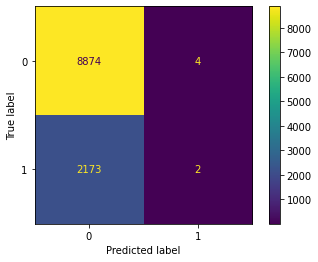

(array([0, 1]), array([11047,     6]))
(array([0, 1]), array([8878, 2175]))


In [130]:
## confusion matrix:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

confusion_matrix = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix, model.classes_).plot()
plt.show()

print(np.unique(pred, return_counts=True))
print(np.unique(y_test, return_counts=True))

In [133]:
## Random Forest

def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 10, 250, step = 10),
    "max_depth": trial.suggest_int("max_depth", 1, 15),
    "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
    "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    "random_state": 50,
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    score=model.score(X_val, y_val)
    
    return score 
start_time = time.time()

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=10)

total_time = time.time()-start_time

[I 2024-04-07 11:40:11,275] A new study created in memory with name: no-name-10f257de-997a-4840-8d26-5a1533b85e87
[I 2024-04-07 11:40:12,315] Trial 0 finished with value: 0.7979091274628066 and parameters: {'n_estimators': 40, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7979091274628066.
[I 2024-04-07 11:40:17,549] Trial 1 finished with value: 0.7979091274628066 and parameters: {'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7979091274628066.
[I 2024-04-07 11:40:19,758] Trial 2 finished with value: 0.7976678729392843 and parameters: {'n_estimators': 150, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.7979091274628066.
[I 2024-04-07 11:40:21,586] Trial 3 finished with value: 0.7975874547647769 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_sampl

In [143]:
## Increase/decrease the number of estimators in random forest and 
#comment on the difference of the classification metrics.

best_n_estimators = study.best_params["n_estimators"]
best_criterion = study.best_params["criterion"]
best_max_depth = study.best_params["max_depth"]
min_samples_split = study.best_params["min_samples_split"]
min_samples_leaf = study.best_params["min_samples_leaf"]

random_state = 50

model = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion, 
                               max_depth=best_max_depth, min_samples_leaf=min_samples_leaf,random_state=random_state)
model.fit(X_train_valid, y_train_valid)
print(model.score(X_test, y_test))
print('precision score: '+ str(precision_score(y_test, pred, average='weighted')))
print('recall score: '+ str(recall_score(y_test, pred, average='weighted')))
print('F1 score: '+ str(f1_score(y_test, pred, average='weighted')))
print(study.best_params)

0.803763684067674
precision score: 0.8422932911335936
recall score: 0.803763684067674
F1 score: 0.7168663462758512
{'n_estimators': 20, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}


## CONCLUSION:
The score for random forest and Decision tree is similar, but Random forest models has a better precision as compared to Decision tree, so I would recommend for predicting show or no shoe for medical appointments. 

### Decision Tree
score: 0.8030398986700443
precision score: 0.7108163501758534
recall score: 0.8030398986700443
F1 score: 0.7158220543303494

best params: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}

### Random Forest
score: 0.803763684067674
precision score: 0.8422932911335936
recall score: 0.803763684067674
F1 score: 0.7168663462758512
best params: {'n_estimators': 20, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}
